In [1]:
import pandas as pd
lib = pd.read_csv('2023_01.csv')
lib1 = pd.read_csv('2023_01.csv')
lib2 = pd.read_csv('2023_02.csv')
lib3 = pd.read_csv('2023_03.csv')
lib4 = pd.read_csv('2023_04.csv')
lib5 = pd.read_csv('2023_05.csv')
lib6 = pd.read_csv('2023_06.csv')
lib7 = pd.read_csv('2023_07.csv')
lib8 = pd.read_csv('2023_08.csv')
lib9 = pd.read_csv('2023_09.csv')
lib10 = pd.read_csv('2023_10.csv')
lib11 = pd.read_csv('2023_11.csv')
lib12 = pd.read_csv('2023_12.csv')

# 파일명을 기반으로 각각의 데이터프레임에 월 정보 추가
lib1['월'] = '01'
lib2['월'] = '02'
lib3['월'] = '03'
lib4['월'] = '04'
lib5['월'] = '05'
lib6['월'] = '06'
lib7['월'] = '07'
lib8['월'] = '08'
lib9['월'] = '09'
lib10['월'] = '10'
lib11['월'] = '11'
lib12['월'] = '12'

# 리스트에 모든 데이터프레임을 넣기
dataframes = [lib1, lib2, lib3, lib4, lib5, lib6, lib7, lib8, lib9, lib10, lib11, lib12]

# concat 함수를 사용하여 모든 데이터프레임을 하나로 결합
combined_df = pd.concat(dataframes, ignore_index=True)

# 발행년도를 정수형으로 변환 (불가능한 경우 NaN으로 변환)
combined_df['발행년도'] = pd.to_numeric(combined_df['발행년도'], errors='coerce')

# 8자리 발행년도 처리: 앞 4자리만 발행년도로 취급
combined_df['발행년도'] = combined_df['발행년도'].apply(lambda x: int(str(int(x))[:4]) if pd.notna(x) and len(str(int(x))) == 8 else x)

# 발행년도가 정수이고, 3자리 이하가 아닌 경우만 필터링
filtered_df = combined_df[(combined_df['발행년도'] >= 1000) & (combined_df['발행년도'] < 10000)]

C:\Users\shs21\AppData\Local\Temp\ipykernel_23100\2069422458.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib = pd.read_csv('2023_01.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_23100\2069422458.py:3: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib1 = pd.read_csv('2023_01.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_23100\2069422458.py:4: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib2 = pd.read_csv('2023_02.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_23100\2069422458.py:5: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib3 = pd.read_csv('2023_03.csv')
C:\Users\shs21\AppData\Local\Temp\ipykernel_23100\2069422458.py:6: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  lib4 = pd.

## 데이터 준비

In [12]:
# 대출건수가 0인 책만 필터링
books_with_zero_loans = filtered_df[filtered_df['대출건수'] == 0].copy()

# 발행년도별로 대출권수와 도서권수 합산
loan_count_by_year = filtered_df.groupby('발행년도')['대출건수'].sum()
book_count_by_year = filtered_df.groupby('발행년도')['도서권수'].sum()

# 비율 계산 (대출권수/도서권수)
loan_to_book_ratio = loan_count_by_year / book_count_by_year

# 데이터프레임에 비율 및 발행년도별 대출권수 추가
books_with_zero_loans.loc[:, '대출권수합계'] = books_with_zero_loans['발행년도'].map(loan_count_by_year)
books_with_zero_loans.loc[:, '대출/도서 비율'] = books_with_zero_loans['발행년도'].map(loan_to_book_ratio)

# 수거 여부를 나타내는 타겟 변수 생성 (예시 기준: 발행년도별 대출권수 <= 500 그리고 대출/도서 비율 < 0.5)
books_with_zero_loans.loc[:, '수거 여부'] = (books_with_zero_loans['대출권수합계'] <= 500) & (books_with_zero_loans['대출/도서 비율'] < 0.5)
# 수거 여부를 나타내는 타겟 변수 생성 (예시 기준: 발행년도별 대출권수 <= 500 그리고 대출/도서 비율 < 0.5)
# 수거 여부를 먼저 명시적으로 bool로 변환한 후 int로 변환
books_with_zero_loans.loc[:, '수거 여부'] = books_with_zero_loans['수거 여부'].astype(int)

C:\Users\shs21\AppData\Local\Temp\ipykernel_23100\3443345181.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  books_with_zero_loans.loc[:, '수거 여부'] = books_with_zero_loans['수거 여부'].astype(int)


## 의사결정트리 모델 학습
이제 간단한 의사결정트리 모델을 학습시키고, 이 모델을 통해 어떤 기준으로 책을 수거할지 판단할 수 있다.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# 특징과 타겟 변수 설정
features = books_with_zero_loans[['발행년도', '도서권수', '대출권수합계', '대출/도서 비율']]
target = books_with_zero_loans['수거 여부']

# 학습용 데이터와 테스트용 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# 의사결정트리 모델 학습
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9999952911483005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    212310
           1       0.98      1.00      0.99        56

    accuracy                           1.00    212366
   macro avg       0.99      1.00      1.00    212366
weighted avg       1.00      1.00      1.00    212366



## 결과 분석 및 기준 제시
의사결정트리 모델의 학습 결과를 통해, 어떤 기준이 수거 여부를 결정하는 데 중요한 역할을 하는지 파악할 수 있다. 
DecisionTreeClassifier는 모델을 시각화하여 어떤 조건들이 주된 판단 기준이 되는지 확인할 수 있다.

In [29]:
# 한글 폰트 경로 설정
import matplotlib.font_manager as fm
# 한글 폰트 경로 설정 (예: 맑은 고딕)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 맑은 고딕 폰트 경로 (Windows의 경우)

# 폰트 등록
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

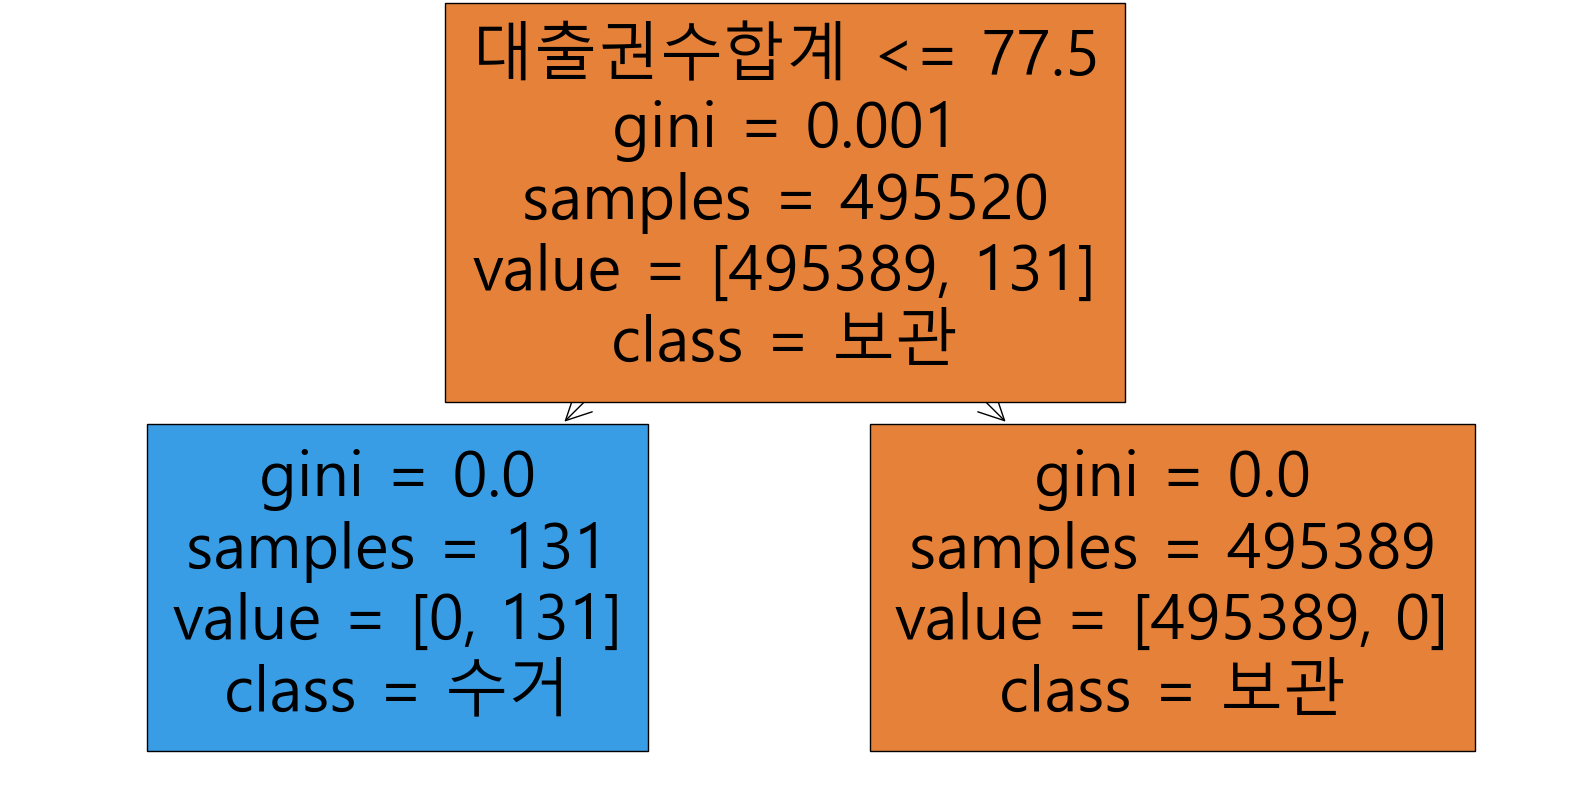

In [31]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 의사결정트리 시각화
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=features.columns, class_names=['보관', '수거'], filled=True)
plt.show()

# 의사결정트리 모델 결과 해석

## 1. 노드의 구성 요소 설명

### `대출건수합계 <= 77.5`:
- 이 조건은 트리가 데이터를 분할하는 기준입니다. 이 경우, 대출건수합계가 77.5 이하인지 여부에 따라 데이터를 두 개의 그룹으로 나눕니다.

### `gini`:
- `gini`는 지니 불순도(Gini impurity)를 나타내며, 분할된 데이터의 순수성(purity)을 측정하는 지표입니다. 값이 0에 가까울수록 해당 노드의 데이터가 한쪽 클래스에 더 많이 속한다는 의미입니다.
- 예를 들어, `gini = 0.001`은 해당 노드가 거의 순수하다는 것을 의미합니다. 즉, 대부분의 데이터가 하나의 클래스에 속합니다.

### `samples`:
- 이 노드에 도달한 데이터 샘플의 수를 나타냅니다. 예를 들어, `samples = 495520`은 이 노드에서 495,520개의 샘플이 있다는 의미입니다.

### `value`:
- 이 노드에 있는 데이터 샘플의 클래스 분포를 나타냅니다. `[보관, 수거]` 클래스에 대한 샘플 수를 의미합니다.
- 예를 들어, `value = [495389, 131]`은 보관 클래스에 속하는 495,389개의 샘플과 수거 클래스에 속하는 131개의 샘플이 있다는 의미입니다.

### `class`:
- 이 노드에서 대부분의 샘플이 속하는 클래스를 나타냅니다. 예를 들어, `class = 보관`은 이 노드에서 대부분의 샘플이 보관 클래스에 속한다는 것을 의미합니다.

## 2. 각 노드의 결과 해석

### 첫 번째 노드:
- **조건**: `대출건수합계 <= 77.5`
- **gini**: 0.001 (거의 순수함)
- **samples**: 495520 (495,520개의 샘플)
- **value**: [495389, 131] (495,389개의 보관 샘플과 131개의 수거 샘플)
- **class**: 보관

이 노드는 대출건수합계가 77.5 이하인지 여부에 따라 데이터를 나눕니다. 대부분의 샘플(495,389개)이 보관 클래스에 속하므로, 이 노드의 지니 불순도는 매우 낮습니다.

### 왼쪽 자식 노드:
- **gini**: 0.0 (완전히 순수함)
- **samples**: 131 (131개의 샘플)
- **value**: [0, 131] (모든 샘플이 수거 클래스에 속함)
- **class**: 수거

이 노드는 대출건수합계가 77.5 이하인 샘플들만을 다룹니다. 이 노드의 모든 샘플은 수거 클래스에 속하므로, 지니 불순도는 0입니다. 즉, 이 조건을 만족하는 모든 책은 수거할 것으로 예측됩니다.

### 오른쪽 자식 노드:
- **gini**: 0.0 (완전히 순수함)
- **samples**: 495389 (495,389개의 샘플)
- **value**: [495389, 0] (모든 샘플이 보관 클래스에 속함)
- **class**: 보관

이 노드는 대출건수합계가 77.5 초과인 샘플들만을 다룹니다. 이 노드의 모든 샘플은 보관 클래스에 속하므로, 지니 불순도는 0입니다. 즉, 이 조건을 만족하는 모든 책은 보관할 것으로 예측됩니다.

## 3. 결론
이 의사결정트리의 결과를 통해 다음과 같은 간단한 규칙을 세울 수 있습니다:
- **대출건수합계가 77.5 이하인 책**은 모두 수거할 책으로 분류됩니다.
- **대출건수합계가 77.5를 초과하는 책**은 모두 보관할 책으로 분류됩니다.

출처) manypeople’s AI study. (2021. 2. 15.). [머신러닝 분류] Decision Tree / 의사결정트리. Tistory. Retrieved August 21, 2024, from https://di-bigdata-study.tistory.com/2
